# Atividade 4 - Seleção de Características

Nesta atividade iremos aplicar algumas técnicas de seleção de características com o intuito de diminuir as dimensões da nossa base de dados e atacar mais uma vez o problema da `Maldição da dimensionalidade`.

Nela iremos aplicar duas técnicas de seleção de características na nossa base de dados e discutiremos os efeitos dessa aplicação.

## 0. Preparação do ambiente

Para os trabalhos desta atividade utilizaremos a base de dados previamente carregada no Github, [neste link](https://github.com/danielbdias/pattern-recognition-studies.git),
em conjunto com alguns scripts auxiliares.

In [1]:
# instala as libs de python necessárias para os testes
!pip install sklearn-genetic
!pip install skrebate

     |████████████████████████████████| 157 kB 1.9 MB/s eta 0:00:01
  Created wheel for sklearn-genetic: filename=sklearn_genetic-0.2-py2.py3-none-any.whl size=6695 sha256=53a54fe5c49ed0bf2006fcf8d1a38347813aed6567b13bd7ac566f13d6bea14e
  Stored in directory: /home/jovyan/.cache/pip/wheels/a4/77/9f/591331f96f88e348db9529c99905a2bc2456a60c3887155f39
Successfully built sklearn-genetic
  Created wheel for skrebate: filename=skrebate-0.6-py3-none-any.whl size=29328 sha256=7a62e6bd73b1ad23fc8ee929038a6492e8886c4beb54dcee0f3d16bfa213cf58
  Stored in directory: /home/jovyan/.cache/pip/wheels/e4/db/14/b8a8a403765155a6dbd9f715d6c435333556c300160dad973a
Successfully built skrebate


In [35]:
# imports de libs necessárias para as análises
from scripts.database import load_datapoints_with_targets, single_category_database_instance_description
from scripts.preprocessing import centralize_observations, transform_to_distances

from genetic_selection import GeneticSelectionCV
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from skrebate import ReliefF

import numpy as np
import pandas as pd

## 1. Base de dados

Para o nosso trabalhos, estamos utilizando o dataset [Grammatical Facial Expressions](https://archive.ics.uci.edu/ml/datasets/Grammatical+Facial+Expressions), que descreve expressões faciais gramaticais da linguagem brasileira de sinais (Libras).

A base possui `27965 instâncias`, subdivididas em 9 expressões: `Interrogativa (qu)`,`Interrogativa (s/n)`, `Interrogativa (dúvida)`, `Negativa`, `Afirmativa`, `Condicional`, `Relativa`, `Tópico` e `Foco`. 

Cada instância é estruturada em `300 características`, que representam 100 pontos com coordenadas (x, y, z) da face. Não há missing values nesses pontos e eles não por um processo de normalização.

Cada ponto representa a seguinte parte da face:
- 0 - 7 (x,y,z) - olho esquerdo
- 8 - 15 (x,y,z) - olho direito
- 16 - 25 (x,y,z) - sobrancelha esquerda
- 26 - 35 (x,y,z) - sobrancelha direita
- 36 - 47 (x,y,z) - nariz
- 48 - 67 (x,y,z) - boca
- 68 - 86 (x,y,z) - contorno da face
- 87 (x,y,z) - iris esquerda
- 88 (x,y,z) - iris direita
- 89 (x,y,z) - ponta do nariz
- 90 - 94 (x,y,z) - linha acima da sobrancelha esquerda
- 95 - 99 (x,y,z) - linha acima da sobrancelha direita

A classificação de instância é binária onde ela pode ser "Com Expressão" ("Expression", onde os pontos representam a expressão facial) ou "Sem Expressão" ("Not Expression", os pontos não representam uma expressão).

Para esta atividade e as próximas, optamos por utilizar utilizar somente as observações da expressão facial `negativa`, primeiro em sua forma bruta e depois pré-processada.

### 1.1 Base "bruta"

A base com os dados brutos (sem tratamentos) apresenta as seguintes estatísticas descritivas:

In [3]:
category = 'negative'
raw_data = load_datapoints_with_targets(category)

raw_data.describe()

,0x,0y,0z,1x,1y,1z,2x,2y,2z,3x,...,97x,97y,97z,98x,98y,98z,99x,99y,99z,target
count,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,...,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000
mean,309.397827,219.230181,1060.284922,306.747875,217.450552,1131.164819,303.378426,216.894622,1193.764597,300.074385,...,336.213900,205.329225,1272.370658,341.628362,207.474289,1184.382114,344.936643,210.218903,986.881744,0.458241
std,10.612048,14.874460,439.370887,10.614432,15.017886,361.558210,10.643030,15.185494,266.930040,10.749632,...,8.731956,13.120294,89.417381,8.828361,12.035667,351.531081,9.283779,11.350090,555.178027,0.498345
min,284.689000,180.156000,0.000000,281.267000,177.075000,0.000000,276.624000,176.110000,0.000000,272.141000,...,316.827000,160.573000,0.000000,321.877000,164.759000,0.000000,325.012000,169.715000,0.000000,0.000000
25%,298.539250,201.938750,1216.000000,295.935750,199.979500,1221.000000,292.494250,199.242250,1225.000000,288.968250,...,328.490000,190.455000,1265.000000,333.771500,193.954250,1275.000000,336.410250,197.584000,1208.000000,0.000000
50%,312.030000,229.251000,1238.000000,309.420500,227.463000,1243.000000,306.307000,227.081500,1256.000000,303.322500,...,335.835000,213.641500,1284.000000,341.306000,214.365500,1294.000000,345.151000,216.028000,1294.000000,0.000000
75%,317.974750,231.949000,1261.000000,315.219000,230.355250,1270.000000,311.805000,229.977750,1280.000000,308.526750,...,342.709500,216.596250,1294.000000,348.130500,217.373750,1299.000000,351.981750,219.523500,1309.000000,1.000000
max,331.248000,239.845000,1299.000000,328.514000,238.110000,1304.000000,325.127000,237.517000,1314.000000,321.947000,...,356.602000,223.180000,1329.000000,362.141000,223.940000,1542.000000,365.228000,225.527000,1563.000000,1.000000


Ela possui um total de `2706 instâncias`, divididas em `1240 (45,81%)` que `representam a expressão` negativa e `1466 (54,17%)` que `não representam a expressão` negativa.

In [36]:
single_category_database_instance_description(category)

,"""Expression"" Instances","""Expression"" Instance Proportion","""Not Expression"" Instances","""Not Expression"" Instance Proportion",Total Instances
0,1240,0.458241,1466,0.541759,2706


### 1.2 Base normalizada

No processo de normalização da base buscamos centralizar cada frame (observação) em relação a um ponto em comum no frame.
Escolhemos o ponto 89 (`nose tip`) como referência e aplicamos o processo nas seguintes etapas:

1.   Encontramos os valores médios para o ponto 89 nos valores de `x` e `y` (ignoramos o valor de `z` por ele usar uma medida em milimetros ao invés de em pixels, [referência](https://archive.ics.uci.edu/ml/datasets/Grammatical+Facial+Expressions#));
2.   Calculamos os deltas do ponto 89 de cada observação em relação aos valores médios encontrados;
3.   Subtraimos esse delta de todos os pontos de cada observação.

Aplicando essa normalização percebemos que a média permaneceu a mesma, mas a amplitude dos dados diminuiu nas bases, o que pode ser constatado pela diferença entre o mínimo e o máximo de cada variável.


In [4]:
# chama a função de centralização dos scripts de pre-processamento
normalized_data = centralize_observations(raw_data)
normalized_data.describe()

,0x,0y,0z,1x,1y,1z,2x,2y,2z,3x,...,97x,97y,97z,98x,98y,98z,99x,99y,99z,target
count,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,...,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000
mean,309.397827,219.230181,1060.284922,306.747875,217.450552,1131.164819,303.378426,216.894622,1193.764597,300.074385,...,336.213900,205.329225,1272.370658,341.628362,207.474289,1184.382114,344.936643,210.218903,986.881744,0.458241
std,1.625597,2.741896,439.370887,1.766325,2.647455,361.558210,1.909747,2.545192,266.930040,2.068360,...,3.905090,5.389459,89.417381,3.914957,6.521451,351.531081,3.385256,7.330508,555.178027,0.498345
min,303.950854,209.797120,0.000000,300.704854,207.540120,0.000000,296.182854,206.904120,0.000000,291.035854,...,324.399854,191.588120,0.000000,329.433854,190.305120,0.000000,333.625854,190.429120,0.000000,0.000000
25%,308.392854,217.153620,1216.000000,305.627854,215.371120,1221.000000,302.096854,214.948620,1225.000000,298.725104,...,332.981354,200.486870,1265.000000,338.390354,201.331120,1275.000000,342.261354,203.145120,1208.000000,0.000000
50%,309.606354,219.179620,1238.000000,306.972854,217.450620,1243.000000,303.588354,217.093620,1256.000000,300.290354,...,335.892854,206.155620,1284.000000,341.439354,208.103120,1294.000000,345.075854,210.954620,1294.000000,0.000000
75%,310.441854,221.674620,1261.000000,307.857104,219.733870,1270.000000,304.494854,219.018620,1280.000000,301.115854,...,340.044854,210.090870,1294.000000,345.416854,213.098120,1299.000000,348.082604,216.895370,1309.000000,1.000000
max,314.504854,224.502120,1299.000000,312.710854,222.920120,1304.000000,310.230854,222.413120,1314.000000,307.853854,...,348.181854,214.912120,1329.000000,356.601854,219.077120,1542.000000,360.888854,223.073120,1563.000000,1.000000


### 1.3 Base transformada: distâncias

Baseando-se no trabalho de [Freitas, 2015](https://teses.usp.br/teses/disponiveis/100/100131/tde-10072015-100311/pt-br.php), página 69, uma outra forma de se analisar a base de dados é calcular a distância entre cada ponto da face utilizar esta distância como uma característica.

Assumimos a distância euclidiana e consideramos apenas as dimensões `x` e `y` dos pontos para o cálculo da distância. Como resultado obtivemos uma base transformada com 4950 características.


In [6]:
# chama a função de transformação em distâncias dos scripts de pre-processamento
final_distance_data = transform_to_distances(raw_data)
final_distance_data.describe()

,p0_p1,p0_p2,p0_p3,p0_p4,p0_p5,p0_p6,p0_p7,p0_p8,p0_p9,p0_p10,...,p95_p97,p95_p98,p95_p99,p96_p97,p96_p98,p96_p99,p97_p98,p97_p99,p98_p99,target
count,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,...,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000,2706.000000
mean,3.205413,6.476448,9.478660,11.748755,9.202654,6.106518,2.901692,16.798252,19.497097,23.002680,...,12.778072,18.209246,21.850599,7.059384,12.735637,16.678649,5.959281,10.267168,4.447170,0.458241
std,0.247745,0.503615,0.768844,1.042167,0.760960,0.464040,0.201136,1.103508,1.221183,1.385173,...,1.636697,1.982570,1.912391,0.974959,1.390997,1.404598,0.548779,0.728717,0.266058,0.498345
min,2.231836,4.633564,6.711327,7.904620,6.344750,4.272977,2.066514,12.743815,14.792254,17.720947,...,8.048500,12.423992,15.753487,4.334107,8.768602,11.763689,4.240763,7.429760,3.322525,0.000000
25%,3.077281,6.200107,8.983846,11.093173,8.723791,5.866282,2.816403,16.445895,19.136490,22.537137,...,11.425022,16.520847,20.261497,6.231333,11.545992,15.542785,5.493498,9.747425,4.291253,0.000000
50%,3.233068,6.549768,9.645038,11.980110,9.382900,6.194151,2.911204,16.878093,19.624454,23.205082,...,12.880073,18.414482,22.070162,7.084695,12.818891,16.816931,6.036570,10.315827,4.425899,0.000000
75%,3.353124,6.776035,9.950912,12.358827,9.664649,6.376175,2.986084,17.310533,19.969964,23.588998,...,14.247652,19.908677,23.473645,7.957682,13.935272,17.861438,6.422613,10.815314,4.579201,1.000000
max,5.031605,10.216324,14.926595,18.403000,14.555318,9.563117,4.419673,24.323058,28.284589,33.847741,...,20.655426,29.027706,33.965082,11.425005,20.226288,25.711146,9.403138,15.653882,6.552885,1.000000


## 2. Seleção de atributos

Optamos por executar as seguintes técnicas de seleção de atributos nas base:
1.   Relief / ReliefF
2.   Algoritmos Genéticos

Para algoritmos que necessitam de um número de atributos a serem encontrados assumimos como valor a raiz quadrada do número de atributos totais da base (critéria recomendado para o `Branch and Bound`).

Esse cálculo pode ser visto na função `expected_features_to_find`.

In [7]:
def expected_features_to_find(data):
    features_to_find_as_double = np.sqrt(len(data.columns) - 1)
    return int(np.round_(features_to_find_as_double, 0))

### 2.1. Relief / Relief-F

O algoritmo Relief é um algoritmo heurístico de seleção de características baseado no cálculo de pesos para essas características. Sua relação com o classificador é do tipo filtro, i.e., aplicamos ele em uma base de dados previamente com o intuito de diminuir as dimensões da base de dados antes de utiliza-la em um classificador.

Neste algoritmo calculamos a importância (peso) de cada característica de algumas observações da base de dados em relação aos vizinhos de cada observação identificando as contribuições de nearMiss e nearHit desses vizinhos.

Utilizamos a implementação do Relief-F, uma versão atualizada do Relief que pode lidar com dados ausentes e dados multiclasse, para a seleção de características. 

Nesta implementação a importância / peso é calculado para todas as características, assim, para podermos decidir o número de características a se utilizar avaliamos dois critérios: 1) estabelecer um número prévio de características a se calcular (considerando uma métrica parecida com o branch-and-bound) e 2) montando um gráfico com a queda de importância das variáveis e definindo empiricamente o ponto de corte.

In [12]:
def reliefF(data, features_to_find, K = 100):
    """Aplica o algoritmo ReliefF em uma base de dados."""
    X = data.values[:,:-1]
    y = data.values[:, -1:].ravel()

    fs = ReliefF(n_features_to_select = features_to_find, n_neighbors = K, n_jobs = -1) # n_jobs -1 usa todos os cores da máquina no calculo
    fs.fit(X, y)

    feature_names = list(normalized_data.drop('target', axis=1).columns)

    feature_importances = pd.DataFrame(
        { 'Feature': feature_names, 'Importance': fs.feature_importances_ },
        columns = ['Feature', 'Importance']
    )

    top_features_indexes = fs.top_features_[:fs.n_features_to_select]
    top_features = list(map(lambda i: feature_names[i], top_features_indexes))

    return feature_importances, top_features

Aplicando o Relief-F na base normalizada com 300 características, encontramos 17 características, com valores de importância variando de 0,126567 a 0,173717. 

In [9]:
# execução do ReliefF para a base normalizada
normalized_features_to_find = expected_features_to_find(normalized_data)
normalized_feature_importances, top_normalized_features = reliefF(normalized_data, normalized_features_to_find)
print(top_normalized_features)

['41x', '40x', '86x', '42x', '39x', '85x', '44x', '53y', '84x', '68x', '60x', '69x', '15x', '63y', '83x', '70x', '14x']


Observando as características selecionadas pode-se perceber que eles representam poucos aspectos da face, entre eles: `olho direito (14, 15)`, `nariz (39, 40, 41, 42, 44)`, `boca (53, 60, 63)` e `contorno da face (68, 69, 70, 83, 84, 85, 86)`.

In [13]:
normalized_feature_importances.sort_values(by=['Importance'], ascending=False).head(normalized_features_to_find).T

,123,120,258,126,117,255,132,160,252,204,180,207,45,190,249,210,42
Feature,41x,40x,86x,42x,39x,85x,44x,53y,84x,68x,60x,69x,15x,63y,83x,70x,14x
Importance,0.173717,0.165571,0.156887,0.156199,0.153837,0.151182,0.150322,0.150234,0.141553,0.135507,0.135269,0.133467,0.133267,0.132648,0.129025,0.127494,0.126567


Plotando um gráfico dos valores de importância encontrados pelo algoritmo percebemos a importância começa com uma valor de 0,17 e ter uma queda brusca até próximo de 35 características. Após essa queda, a importância decresce de forma mais linear. 

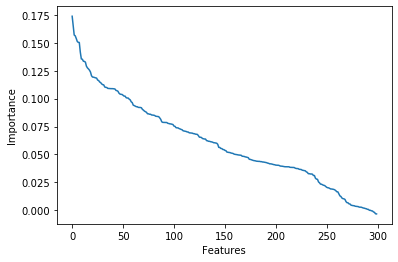

In [17]:
import matplotlib.pyplot as plt

plot_y = list(normalized_feature_importances.sort_values(by=['Importance'], ascending=False)['Importance'])
plot_x = list(range(0, len(plot_y)))

plt.ylabel('Importance')
plt.xlabel('Features')
plt.plot(plot_x, plot_y)
plt.show()

In [19]:
normalized_feature_importances.sort_values(by=['Importance'], ascending=False).head(35)

,Feature,Importance
123,41x,0.173717
120,40x,0.165571
258,86x,0.156887
126,42x,0.156199
117,39x,0.153837
255,85x,0.151182
132,44x,0.150322
160,53y,0.150234
252,84x,0.141553
204,68x,0.135507


Ao aplicar o Relief-F na base de dados transformada com as distâncias, não obtivemos um resultado para o algoritmo após 1 hora de execução. Acreditamos que ele é mais demorado por ter um número muito grande de características (4950).


In [ ]:
# execução do ReliefF para a base de distâncias
distance_features_to_find = expected_features_to_find(final_distance_data)
distance_feature_importances, top_distance_features = reliefF(final_distance_data, distance_features_to_find)
print(top_distance_features)
# Timeout =( 

### 2.2. Algoritmos genéticos

Os algoritmos genéticos constituem uma técnica de busca e otimização, altamente paralela, inspirada no princípio Darwiniano de seleção natural. No contexto de seleção de características, utilizamos esta técnica como um wrapper, onde modelamos cada gene de um cromossomo como uma característica e modelamos a função fitness como o desempenho desse classificador.

Neste trabalho utilizamos como classificador a Regressão Logística, recebendo os dados normalizados entre 0 e 1, e os seguintes parâmetros para o algoritmo genético:
- Número máximo de gerações: 300
- Probabilidade de mutação: 0,5%
- Métrica de fitness: acurácia do classificador
- População inicial: 50



In [39]:
def genetic_algorithm(data, population_size=50, generations=300, mutation_probability=0.05, fitness="accuracy"):
    estimator = linear_model.LogisticRegression(multi_class="ovr", max_iter=10_000)
    selector = GeneticSelectionCV(estimator, n_gen_no_change=10, caching=True, n_jobs=-1, verbose=1, scoring=fitness,
                                  n_population=population_size, mutation_proba=mutation_probability, n_generations=generations)

    X = data.values[:,:-1]
    y = data.values[:, -1:].ravel()

    normalized_X = StandardScaler().fit_transform(X)

    selector.fit(normalized_X, y)

    feature_names = list(data.drop('target', axis=1).columns)
    selected_features = []

    for index, has_attribute in enumerate(selector.support_):
        if has_attribute:
            selected_features.append(feature_names[index])

    final_score = selector.score(normalized_X, y)
            
    return selected_features, selector.generation_scores_, final_score

Aplicando a seleção de características utilizando algoritmos genéticos na base normalizada em 38 gerações, conseguimos reduzir de 300 características para 156, uma redução de 48% da base de dados.

In [40]:
selected_features, generation_scores, final_score = genetic_algorithm(normalized_data)

Selecting features with genetic algorithm.
gen	nevals	avg                        	std                    	min                        	max                        
0  	50    	[  0.75402454 150.58      ]	[0.00919635 7.24179536]	[  0.72318039 135.        ]	[  0.77492207 167.        ]
1  	27    	[  0.76172758 150.6       ]	[4.99243512e-03 7.24154680e+00]	[  0.75200565 138.        ]	[  0.77492207 169.        ]
2  	27    	[  0.76588222 151.18      ]	[5.52098156e-03 6.81378015e+00]	[  0.75348507 134.        ]	[  0.77566144 167.        ]
3  	26    	[  0.77039885 151.32      ]	[3.70138184e-03 5.27044590e+00]	[  0.76272926 136.        ]	[  0.7764015 167.       ]  
4  	32    	[  0.77311867 151.2       ]	[3.10238442e-03 4.27083130e+00]	[  0.76346386 134.        ]	[  0.77935626 159.        ]
5  	25    	[  0.77515144 152.56      ]	[2.09893063e-03 3.40094105e+00]	[  0.76974852 147.        ]	[  0.77935626 159.        ]
6  	21    	[  0.77650382 152.68      ]	[1.22761440e-03 3.86491915e+00]	[  0.77307569

In [41]:
print(selected_features)

['1x', '1y', '2x', '2y', '2z', '3x', '4z', '5y', '6z', '7z', '8x', '8y', '8z', '9x', '9z', '11x', '11y', '11z', '12x', '12z', '13y', '14x', '14y', '15y', '16y', '17y', '18x', '18y', '18z', '19x', '19z', '20x', '20y', '21x', '21z', '22z', '23y', '23z', '24x', '24y', '24z', '25x', '25z', '27y', '28x', '28y', '28z', '31y', '32z', '33x', '33y', '33z', '34y', '35x', '35z', '36x', '37x', '37y', '37z', '38x', '39y', '39z', '40z', '41y', '41z', '42x', '42y', '42z', '43x', '43y', '43z', '44x', '44y', '45z', '46y', '46z', '47z', '48y', '49x', '49y', '50x', '50y', '52z', '53x', '53y', '54x', '54z', '55y', '56x', '56y', '56z', '57x', '57y', '57z', '58x', '58y', '58z', '59x', '60z', '62x', '62y', '62z', '63y', '63z', '66z', '67y', '67z', '68x', '69x', '69y', '70z', '71y', '71z', '72y', '73y', '74y', '74z', '75y', '76x', '76y', '78z', '79z', '80y', '80z', '81y', '81z', '82x', '82y', '83x', '83z', '84x', '84y', '84z', '85y', '85z', '86y', '87z', '88x', '89y', '90x', '90y', '91z', '92y', '92z', '93y',

Das características selecionadas, praticamente todas pertecem a algum ponto da face, em alguns casos com pontos tendo uma das coordenadas x,y,z descartadas.

In [42]:
len(selected_features)

156

In [43]:
print(final_score)

0.8614190687361419


In [ ]:
distance_selected_features, generation_scores, final_score = genetic_algorithm(final_distance_data)
print(distance_selected_features)
# timeout

Novamente, ao aplicar o algoritmo de seleção na base transformada de distâncias novamente não obtivemos resultados após 1 hora de execução.

## 3. Discussão sobre os resultados

Com o algoritmo Relief-F conseguimos reduzir a base de dados em `94%` (de `300 características para 17`) utilizando o critério de raiz quadrada do total de características, ou em `88%` (de `300 para 35`) através da inspeção visual plotando a queda dos pesos em relação ao número de características.
Como algumas vantagens neste algoritmo: 1) temos uma métrica de peso das características da base de dados, que nos dá uma pista de quais características podem influenciar mais na discriminação das classes; 2) por usar a estratégia de filtro, não vincular o resultado a um classificador em específico; e 3) o algoritmo executa em um tempo razoável (levou cerca de 10 minutos). Em contrapartida, não temos certeza de qual será a acurácia de classificação desta base reduzida.

Já com o algoritmo genético conseguimos reduzir a base em `48%`, de `300 para 156 características`. Como vantagem deste algoritmo temos uma garantia de acurácia da base de dados (`86,14%`) por ele trabalhar como um wrapper em um classificador e podemos olhar a base de dados de um ponto de vista mais global, vendo como um grupo de características como um todo impacta na discriminação de uma classe, muitas vezes nos entregando respostas que fogem ao óbvio, mesmo que não sejam a melhor possível (por não um máximo global).

Um ponto se investigar mais nestes algoritmos também seria o como eles lidam com bases grandes. Ambos os testes com a base transformada de distâncias os algoritmos não terminaram de executar no prazo de 1 hora, provalvemente por conta de essa base ser 16,5 vezes maior que a base com só as coordenadas, devido ao alto número de características (4950). Com o intuito de fazer mais alguns testes nesta base e futuramente entender se com uma outra representação podemos discriminar melhor as classes nas atividades futuras, podemos estabelecer um tempo maior de execução dos algoritmos para esta base (provavelmente 1 dia).


## 4. Referências

Bibliotecas Python utilizadas:
- [Scikit-Rebate](https://github.com/EpistasisLab/scikit-rebate)
- [Sklearn-Genetic](https://github.com/manuel-calzolari/sklearn-genetic)